<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>House price estimation with multiple input</h1>
</div>

In this notebook, you will learn how to use the functional Keras API to implement a regressor with neural networks. 

## Content

1. Load the Data
    - Import libraries.
    - Load the datasets.
    
2. Overview of the Data.
    - Descriptive Statistics.
    - Missing Values.
    
3. Exploratory Data Analysis.
    - Create a list of columns by data type.
    - Check the distribution of target class
    - Check the distribution of every feature.
    
4. Data Preparation.
    - Data Cleaning.
    - Feature encoding.
    - Split X & Y
    - Feature Scaling.
    
5. Model Building.
    - Defining the model.
    - Train model.
    - Model prediction.
    - Model evaluation.

6. Improve the model.
    - Handle the outlier values.
    - Scaling the data.
    - Building the new model.
    - Training the new model.
    - Model prediction.
    - Model evaluation.
    - Saving the model.

7. Conclusions.


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Load the Data</h2>
</div>

In this section you will:

- Import the libraries.
- Load the dataset.

### 1.1 Import Libraries

In [2]:
#Import libraries

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt

#Data Manipulation
import pandas as pd
import numpy as np


### 1.2 Load the datasets

In [8]:
#dataset path
#change this path for you data path
data_path = "../../../Houses-dataset/Houses-Dataset/HousesInfo.txt"

#column names
names = ["bedrooms","bathrooms","area","zipcode","price"]

#read the data
df = pd.read_csv(data_path, header = None, sep = " ", names = names)

df.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Overview of the Data.</h2>
</div>

The dataset I'll use for this project can be found in the next [link](https://github.com/emanhamed/Houses-dataset), this dataset contains both visual and textual information for house prices estimation. Each house in the dataset is represented by four images for bedroom, bathroom, kitchen and frontal image of the house. 

The dataset also contains a text file with textual metadata, each row represents the number of houses in order. The numbers represent the number of bedrooms, number of bathrooms, area of the house, zip code and the price.

### 2.1 Descriptive Statistics.

Let's use the `describe()` method of pandas to understend the dataset we have

In [9]:
#Summary of the data
df.describe()

,bedrooms,bathrooms,area,zipcode,price
count,535.000000,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,90937.768224,5.893628e+05
std,1.160952,0.995077,1224.556982,7141.857452,5.090261e+05
min,1.000000,1.000000,701.000000,36372.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,92276.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,92880.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,93510.000000,7.285000e+05
max,10.000000,7.000000,9583.000000,98021.000000,5.858000e+06


Using the method `describe()` we can see some information about the dataset we have, we can have a picture of each column (feature):

+ Mean, mediam, model, standard deviation.
+ Min and Max.
+ Count.
+ Quartiles.

In [10]:
# Dimension of the dataset
df.shape

(535, 5)

### Missing Values

Get the infoabout missing values in the dataframe

In [11]:
#missing values of every column
df.isna().sum()

bedrooms     0
bathrooms    0
area         0
zipcode      0
price        0
dtype: int64

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3.Exploratory Data Analysis.</h2>
</div>

The data set is formed of five variables, the target value is the house's price and the rest of the variables are features that I will use to predict the target value. In the data set we see one categorical variable which is the zip code. The number of bedrooms, the number of bathrooms and the area columns represent numerical variables.

<AxesSubplot:xlabel='count', ylabel='zipcode'>

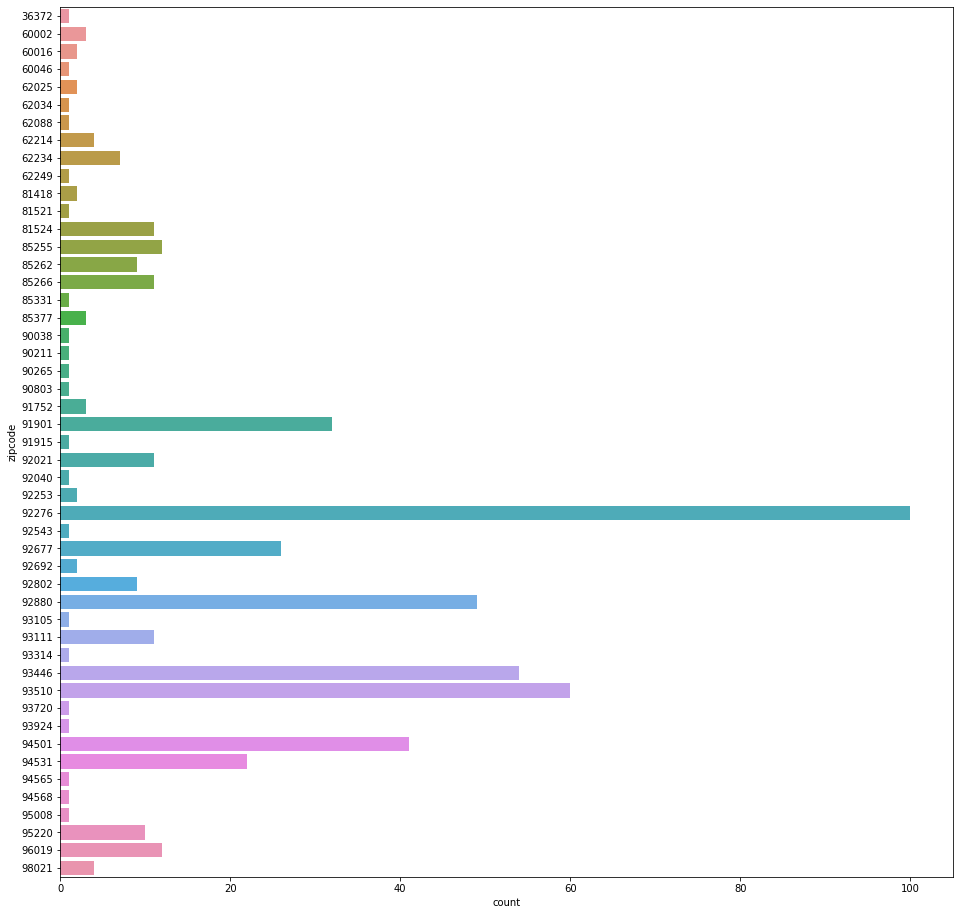

In [12]:
plt.figure(figsize=(16,16))
sn.countplot(y=df["zipcode"], data = df)

House distribution by zip code is highly unbalanced, so we need to pay special attention about how to feed any model with this feature since we have sometimes one or two houses by zip code. Now let's see how the rest of features are distributed.

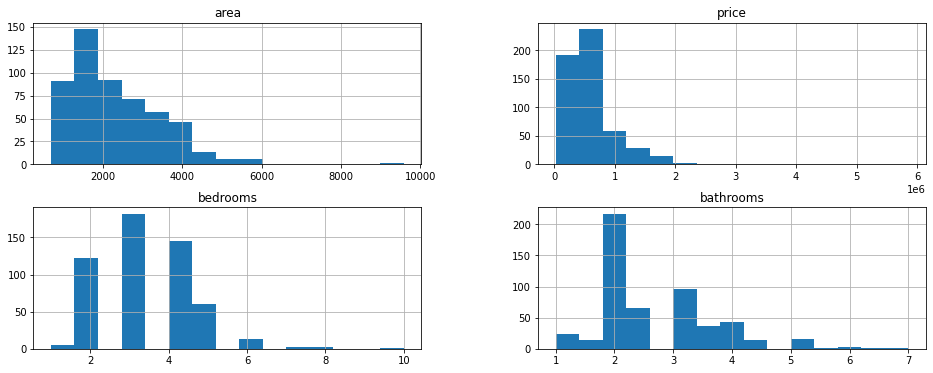

In [13]:
# Check the distribution of the area and price columns
df[["area","price", "bedrooms","bathrooms"]].hist(figsize=(16,6),bins = 15)
plt.show()

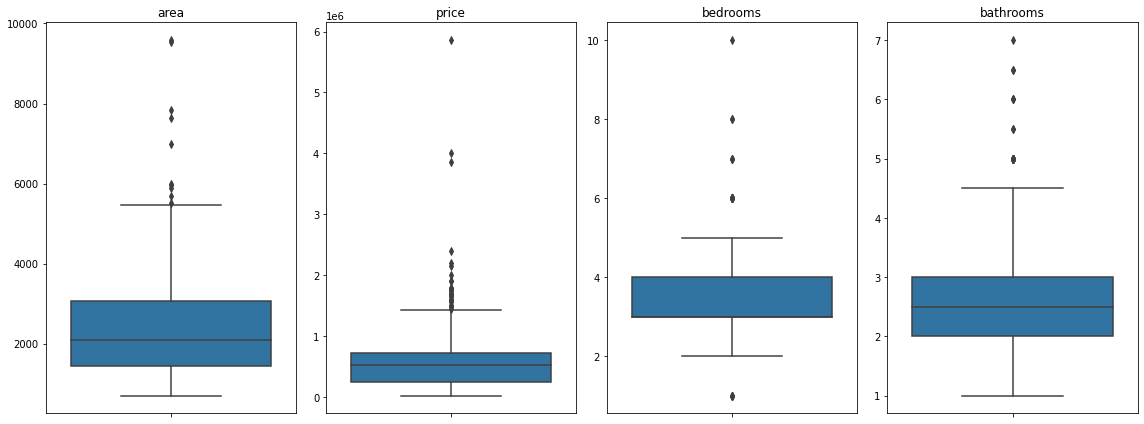

In [14]:
# Check the distribution of each variable
fig,ax = plt.subplots(nrows = 1, ncols = 4, figsize=(16,6))
for i,label in enumerate(["area","price", "bedrooms","bathrooms"]):
    sn.boxplot(x = df[label].values, orient = "v" ,ax = ax[i])
    ax[i].set_title(label)
    
plt.tight_layout()
plt.show()

Looking at the feature distributions we can see there are values in each feature that can be considered as outliers, it is important to take this into account to understand how our model behavior is. For now, I will concentrate more on the zipcode feature.


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Data preparation.</h2>
</div>

### 4.1 Data cleaning.

#### Zipcode feature

In this scenario as we saw in the previous section the zipcode feature is highly unbalanced 
I will remove all the zip code rows having less than 20 houses.



In [15]:
zipcode_rm = df["zipcode"].value_counts()
for idx, val in zip(df["zipcode"].value_counts().keys().tolist(), df["zipcode"].value_counts().values.tolist()):
    if val <= 20:
        df.drop(df[df["zipcode"]==idx].index, inplace = True)

Now let's see what the distribution looks like with the changes in the zip code column.

<AxesSubplot:xlabel='count', ylabel='zipcode'>

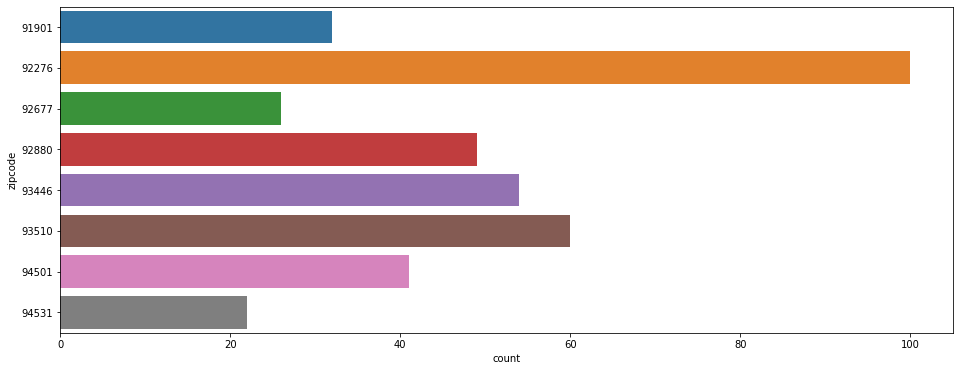

In [16]:
plt.figure(figsize=(16,6))
sn.countplot(y=df["zipcode"], data = df)

### 4.2 Feature encoding.

The next step is to convert all the categorical data in indicator variables, I'll do this using the `get_dummies()` method from pandas.

In [17]:
def processing_data(df):
    # categorical variable
    df_zipcode = pd.get_dummies(df.zipcode, prefix = "z")

    df_num = df[["bedrooms","bathrooms","area","price"]]
    
    #Mixing the data
    processed_data = pd.concat([df_zipcode, df_num] , axis = 1)
    
    return processed_data

In [18]:
#encoding categorical variables
df = processing_data(df)

df.head()

,z_91901,z_92276,z_92677,z_92880,z_93446,z_93510,z_94501,z_94531,bedrooms,bathrooms,area,price
30,0,0,0,0,1,0,0,0,5,3.0,2520,789000
32,0,0,0,0,1,0,0,0,3,2.0,1802,365000
39,0,0,0,0,1,0,0,0,3,3.0,2146,455000
80,1,0,0,0,0,0,0,0,4,2.5,2464,599000
81,1,0,0,0,0,0,0,0,2,2.0,1845,529800


In [19]:
df.shape

(384, 12)

### 4.3  Feature Scaling

We need to scale the values of our dataset, however, since we need to perform two scaling processes I will split the data into training and testing datasets in the same function, in this way I am going to use the parameters used on the training dataset to scale the testing dataset.

In [20]:
def scaling_splitting_data(df, test_size=0.2):    
    #splitting the data
    train, test = train_test_split(df, test_size = test_size, random_state = 43)
    
    #training data
    x_train = train.drop(["price"], axis = 1)
    y_train = train["price"]
    
    #testing data
    x_test = test.drop(["price"], axis = 1)
    y_test = test["price"]
    
    #min max scaler
    data_scaler = MinMaxScaler()
    
    #scaling the train data
    x_train_scaled = data_scaler.fit_transform(x_train)
    y_train_scaled = y_train/np.max(y_train)
    
    #scaling the test data
    x_test_scaled = data_scaler.transform(x_test)    
    y_test_scaled = y_test/np.max(y_train)
        
    return {
        "x_train":x_train,
        "y_train":y_train,
        "x_test":x_test,
        "y_test":y_test,
        "x_train_scaled":x_train_scaled,
        "y_train_scaled":y_train_scaled,
        "x_test_scaled":x_test_scaled,
        "y_test_scaled":y_test_scaled,
        "data_scaler":data_scaler,
    }

In [21]:
processed_df = scaling_splitting_data(df)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Model building</h2>
</div>

### 5.1 Defining the model.

In this case we are dealing with a regression problem, there are many methods to deal with this kind of problem, but for this time I will use tensorflow and keras to build a regression model. Keras offers the opportunity to create neural network architectures easily and faster. The functional API allows more flexibility to build our models.

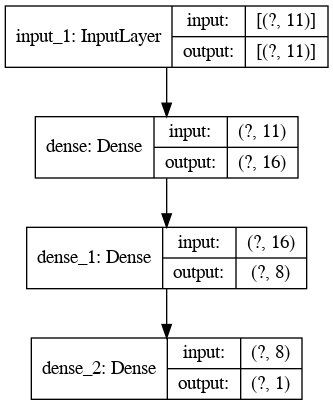

In [22]:
def create_model(processed_df):

    input_layer = Input(shape=(processed_df["x_train_scaled"].shape[1]))

    # dense layers
    first_dense = Dense(16, activation= "relu")(input_layer)
    second_dense = Dense(8, activation = "relu")(first_dense)

    #last layer (regression output)
    last_layer = Dense(1, activation ="linear")(second_dense)

    #creating the model
    model = Model(inputs = input_layer, outputs = last_layer)
    
    return model

model = create_model(processed_df)

#plot model
plot_model(model, show_shapes=True)

In the input layer I am defining the shape of the training data set,  the first dense and second dense layers which have 16 and 8 neurons respectively using the "relu" activation function. The last layer since will be the output layer needs only one output and should use the "linear" activation function since it is a regression problem. Finally, I built the model defining the inputs and outputs model.

### 5.2 Train the model.

To train the model I need to use the compile method to define the loss function and the metric to be used.

In [23]:
#use adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.001)

#use mean absolute error as loss function
model.compile(optimizer= optimizer, loss="mae")

#train the model
history = model.fit(
    x = processed_df["x_train_scaled"],
    y = processed_df["y_train_scaled"],
    epochs = 200,
    validation_data = (processed_df["x_test_scaled"], processed_df["y_test_scaled"]),
    batch_size = 16,
    verbose = 0
)

Now let's look at the training process history, we can see that both the loss metric and the root mean squared error are high at the beginning and decrease gradually through the epochs, we can notice how the validation metric is always higher than the metric obtained with the training data.

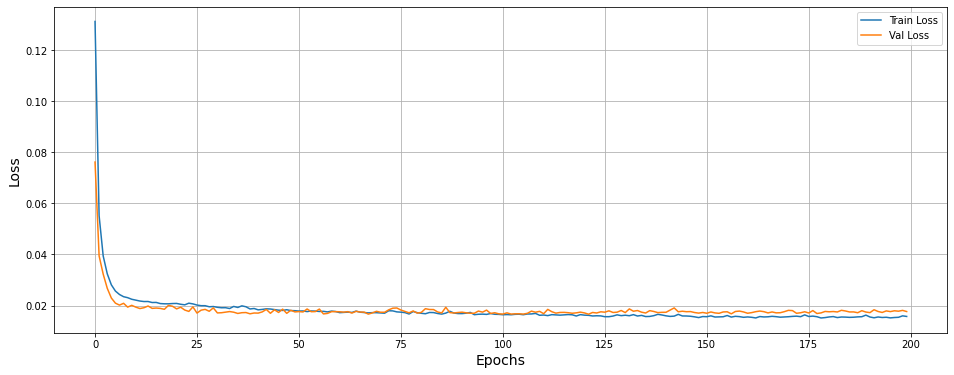

In [24]:
plt.figure(figsize=(16,6))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.grid()
plt.legend(loc = "best")

### 5.3 Model prediction

In this case let's do some manipulations before to start with the predictions.

In [25]:
#Getting predictions on test data
predictions = model.predict(processed_df["x_test_scaled"]).flatten()

#transforming the data to the normal scale
max_price = max(processed_df["y_train"])
predictions = predictions * max_price

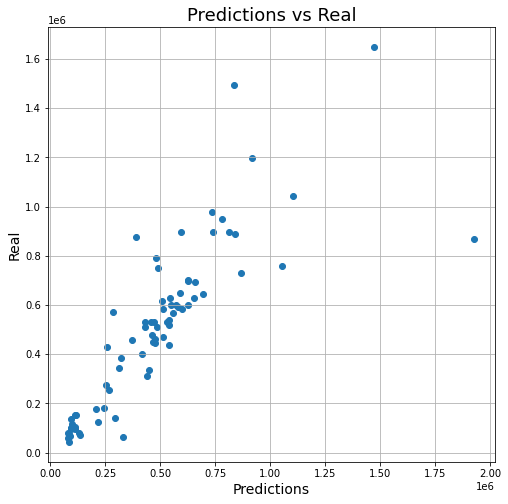

In [26]:
plt.figure(figsize = (8,8))
plt.scatter(predictions, processed_df["y_test"])
plt.title("Predictions vs Real", fontsize = 18)
plt.xlabel("Predictions", fontsize = 14)
plt.ylabel("Real", fontsize = 14)
plt.grid()

In the figure above we can see how the model predicts the majority of the values, however, there are some values which do not match with the prediction.

### 5.4 Model evaluation

Let's use some commun metrics used to evaluate regression models, this will be:

+ Mean Absolute Error (MAE)
+ Root Mean Squared Error (RMSE)

In [27]:
#error
error = predictions-processed_df["y_test"]

#mean absolute error 
mae = np.round(np.mean(np.abs(error)),2)

#root mean squared error
rmse = np.round(np.sqrt(np.mean(np.square(error))),2)

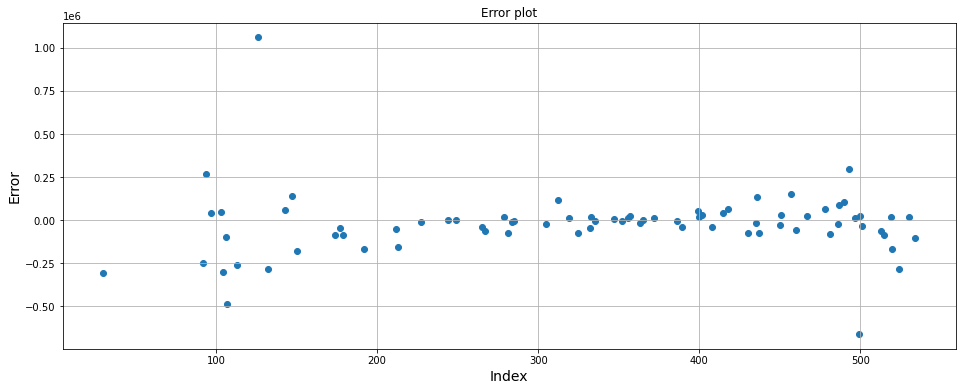

In [28]:
#error plot
plt.figure(figsize = (16,6))
plt.scatter(error.index, error.values)
plt.ylabel("Error", fontsize = 14)
plt.xlabel("Index", fontsize = 14)
plt.title("Error plot")
plt.grid()

In [29]:
print(f"MAE: {mae} RMSE: {rmse}")

MAE: 103333.74 RMSE: 189000.28


The MAE is around $ 100 k this implies a poor performance, however if we do not take into account the big values the performance would be better, for example, let's use the median instead of the mean value to calculate a new metric.

In [30]:
mdae = np.round(np.median(np.abs(error)),2)

print(f"MDAE: {mdae}")

MDAE: 48926.89


Since the median is more robust against anomalous values we have a better metric value, however we need to improve this model. 

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>6. Improve the model.</h2>
</div>

### 6.1 Handle the outlier values

Let's remove the outlier values to improve the model performance. Let's remove all the houses with price higher than $ 700 k, houses with an area higher than 8000 and houses with more than 7 bedrooms.

In [31]:
df.shape

(384, 12)

In [32]:
df2 = df[(df["price"]<= 700000) & (df["area"]<=8000) & (df["bedrooms"]<=7)]

df2.shape

(307, 12)

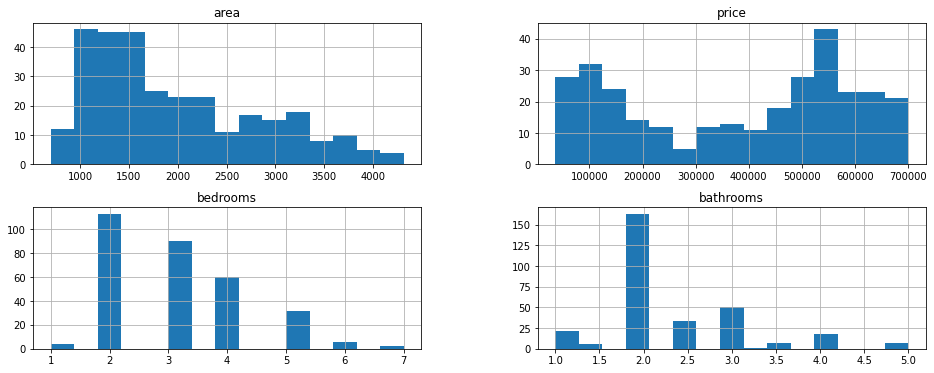

In [33]:
# Check the distribution of the area and price columns
df2[["area","price", "bedrooms","bathrooms"]].hist(figsize=(16,6),bins = 15)
plt.show()

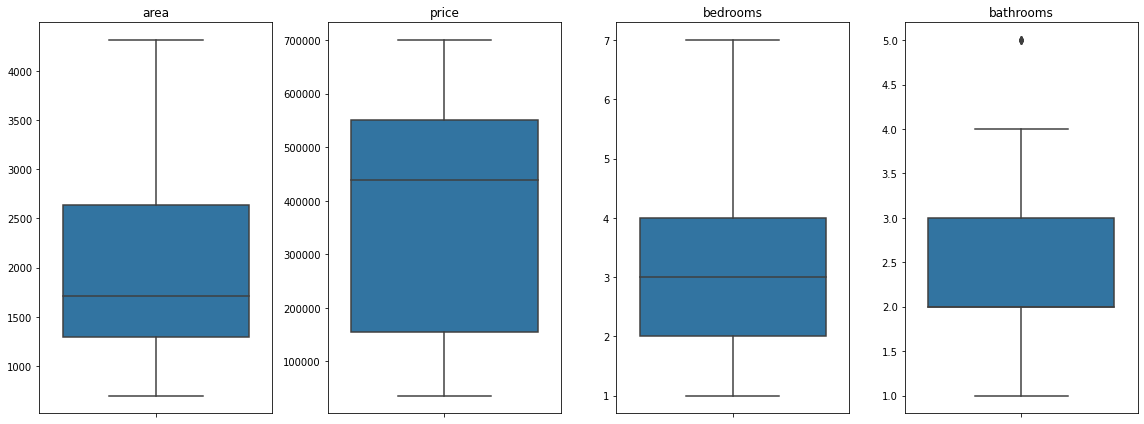

In [34]:
# Check the distribution of each variable
fig,ax = plt.subplots(nrows = 1, ncols = 4, figsize=(16,6))
for i,label in enumerate(["area","price", "bedrooms","bathrooms"]):
    sn.boxplot(x = df2[label].values, orient = "v" ,ax = ax[i])
    ax[i].set_title(label)
    
plt.tight_layout()
plt.show()

### 6.2 Scaling the data

In [35]:
processed_df2 = scaling_splitting_data(df2)

### 6.3 Building new model

In [36]:
model2 = create_model(processed_df2)

### 6.4 Training the new model.

In [37]:
#use adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.001)

#use mean absolute error as loss function
model2.compile(optimizer= optimizer, loss="mae")

#train the model
history_model2 = model2.fit(
    x = processed_df2["x_train_scaled"],
    y = processed_df2["y_train_scaled"],
    epochs = 200,
    validation_data = (processed_df2["x_test_scaled"], processed_df2["y_test_scaled"]),
    batch_size = 16,
    verbose = 0
)

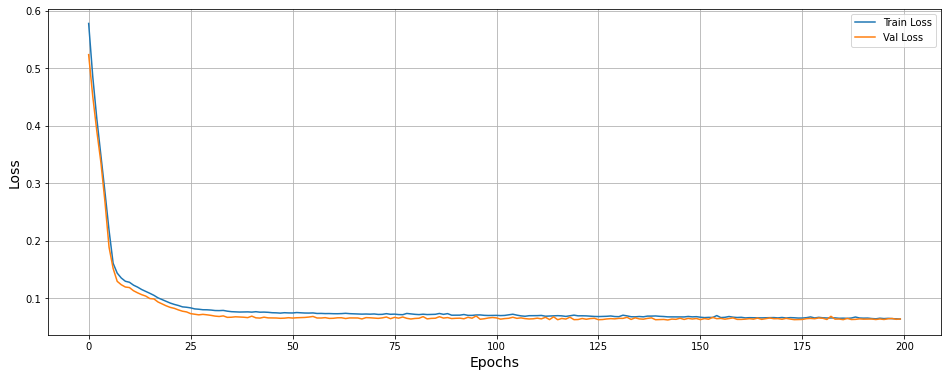

In [38]:
plt.figure(figsize=(16,6))
plt.plot(history_model2.history["loss"], label = "Train Loss")
plt.plot(history_model2.history["val_loss"], label = "Val Loss")
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.grid()
plt.legend(loc = "best")

### 6.5 Model prediction

In [39]:
#Getting predictions on test data
predictions2 = model2.predict(processed_df2["x_test_scaled"]).flatten()

#transforming the data to the normal scale
max_price2 = max(processed_df2["y_train"])
predictions2 = predictions2 * max_price2

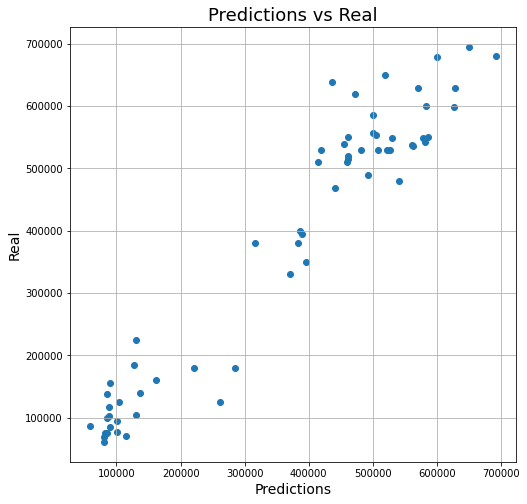

In [40]:
plt.figure(figsize = (8,8))
plt.scatter(predictions2, processed_df2["y_test"])
plt.title("Predictions vs Real", fontsize = 18)
plt.xlabel("Predictions", fontsize = 14)
plt.ylabel("Real", fontsize = 14)
plt.grid()

### 6.6 Model evaluation.

In [41]:
#error
error2 = predictions2-processed_df2["y_test"]

#mean absolute error 
mae2 = np.round(np.mean(np.abs(error2)),2)

#root mean squared error
rmse2 = np.round(np.sqrt(np.mean(np.square(error2))),2)

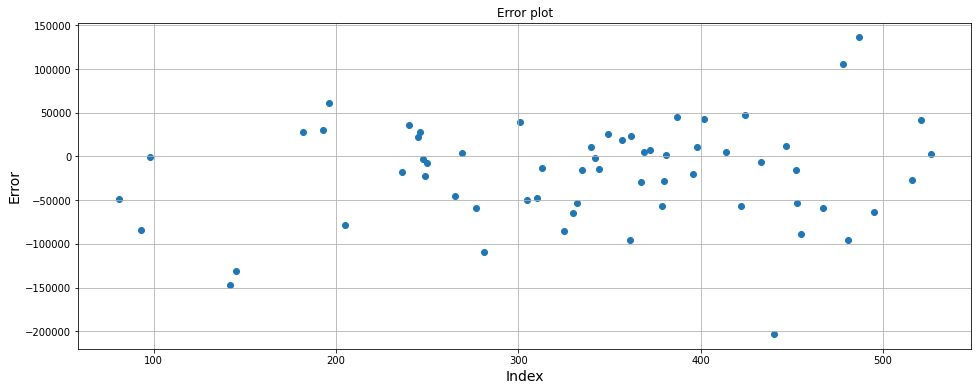

In [42]:
#error plot
plt.figure(figsize = (16,6))
plt.scatter(error2.index, error2.values)
plt.ylabel("Error", fontsize = 14)
plt.xlabel("Index", fontsize = 14)
plt.title("Error plot")
plt.grid()

In [43]:
print(f"MAE: {mae2} RMSE: {rmse2}")

MAE: 44978.34 RMSE: 60689.63


In [44]:
mdae2 = np.round(np.median(np.abs(error2)),2)

print(f"MDAE: {mdae2}")

MDAE: 32887.31


In [45]:
#Save the final data set used
df2.to_csv("output/final_house_price_prediction.csv", index = True)

### 6.7 Saving the final model.

In [46]:
model2.save("output/house_price_regressor")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: output/house_price_regressor/assets


### 7. Conclusions

In this notebook we saw how to use the functional API of tensorflow to solve a regression problem. We also noticed how the presence of outliers affects the model performance. In the next part I am going to include the house image data to improve the house price prediction.